In [1]:
import sys
sys.path.append('..')

from scripts.GenrationGI0 import rGI0, partitioned_gi0_image
from scripts.autoencoders import InMemoryImageDataset, generate_multiple_images

import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import DataLoader

---
### Empiezo graficando algunos ejemplos de imagenes

In [7]:
g, gi, gI0 = rGI0(n=100*100, p_alpha=-1.5, p_gamma=1, p_Looks=1)

In [8]:
g = g.reshape(100, 100)
gi = gi.reshape(100, 100)
gI0 = gI0.reshape(100, 100)

Text(0.5, 1.0, 'Ruido speckle ~ Gamma')

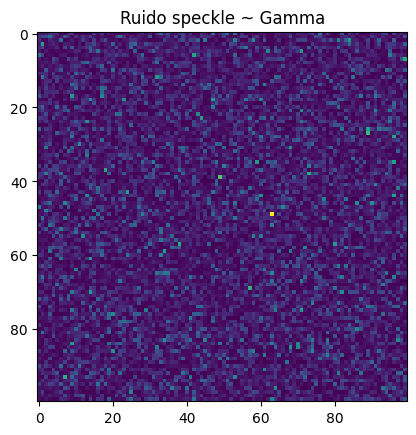

In [9]:
plt.imshow(g)
plt.title('Ruido speckle ~ Gamma')

Text(0.5, 1.0, 'Backscatter ~ Gamma inversa')

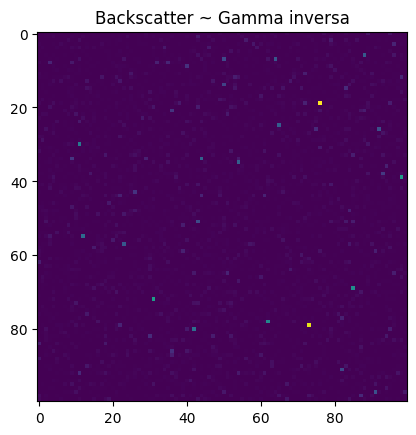

In [10]:
plt.imshow(gi)
plt.title('Backscatter ~ Gamma inversa')

Text(0.5, 1.0, 'Imagen + ruido speckle ~ GI0')

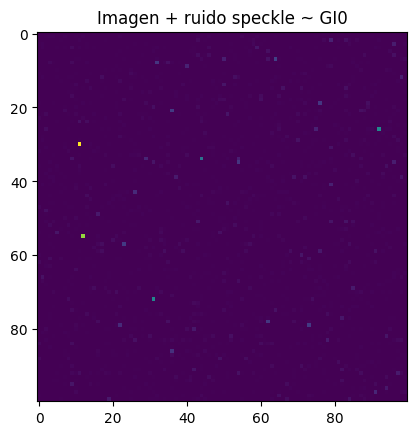

In [11]:
plt.imshow(gI0)
plt.title('Imagen + ruido speckle ~ GI0')

In [27]:
imagen_g, imagen_gi, imagen_gI0 = partitioned_gi0_image(
    p_alphas=[-1.5,-5,-1.7,-10],
    p_gammas=[1,1,1,1],
    p_looks=[1,1,1,1]
)

Text(0.5, 1.0, 'Imagen particionada - Ruido speckle ~ Gamma')

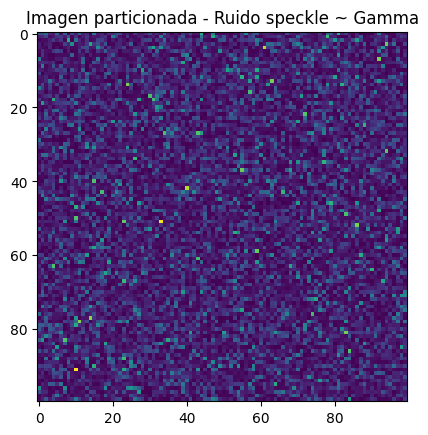

In [28]:
plt.imshow(imagen_g)
plt.title('Imagen particionada - Ruido speckle ~ Gamma')

Text(0.5, 1.0, 'Imagen particionada - Backscatter ~ Gamma inversa')

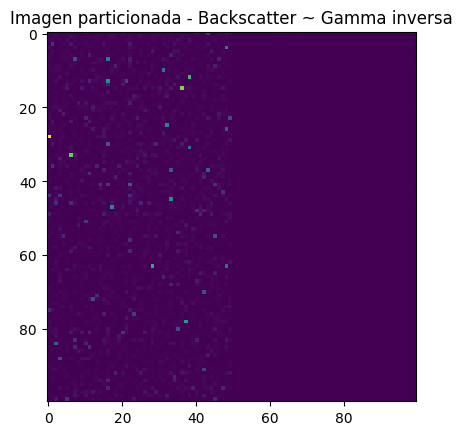

In [29]:
plt.imshow(imagen_gi)
plt.title('Imagen particionada - Backscatter ~ Gamma inversa')

Text(0.5, 1.0, 'Imagen particionada - Imagen + ruido speckle ~ GI0')

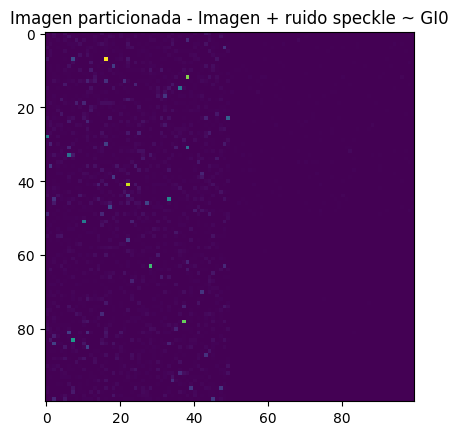

In [30]:
plt.imshow(imagen_gI0)
plt.title('Imagen particionada - Imagen + ruido speckle ~ GI0')

---
### Genero un dataset para entrenar

In [2]:
n = 1000
train_g, train_gi, train_gI0 = generate_multiple_images(n, partitioned_gi0_image)

In [3]:
batch_size = 32

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_train = InMemoryImageDataset(train_gI0, train_gi, transform=transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [20]:
entrada_red, salida_red = dataset_train[21]

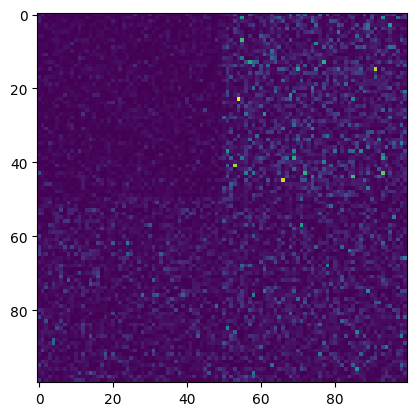

In [21]:
plt.imshow(entrada_red[0,:,:])

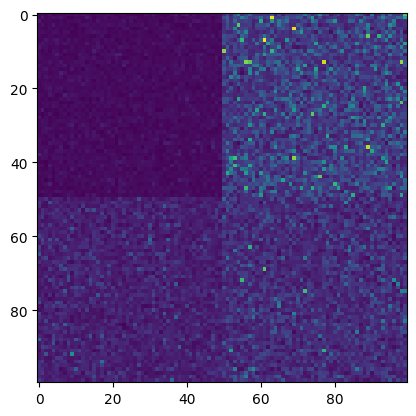

In [18]:
plt.imshow(salida_red[0,:,:])

---
### Entreno